In [1]:
import tensorflow as tf

%load_ext autoreload
%autoreload 2
tfe = tf.contrib.eager
import tensorflow.contrib.eager as tfe

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os

import skimage
import scipy.io
from skimage.transform import rescale

from functions_for_Josh import *
#from admm_rgb import *
#from model_unrolled_layered import *

import model_color as my_model_color

import scipy
import sys

import cv2 as cv


# Parameters 

In [2]:
eager_enabled = True

if eager_enabled == True:
    tf.enable_eager_execution()


In [3]:
config = tf.ConfigProto()
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [4]:
opts = {'psf_file': '/media/hongdata/Kristina/DiffuserLearningData/12_3_2018/data/psf_white_LED_Nick.tiff',
        'down_sizing': 4,
       }


## Load in PSF 

The shape of the loaded diffuser is:(1080, 1920, 3)
The shape of the downsized diffuser is:(270, 480)


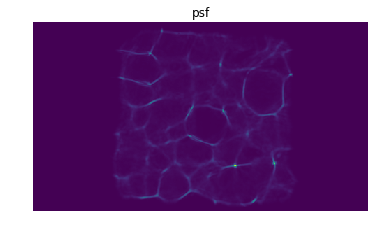

In [5]:
psf_diffuser = load_psf_image(opts['psf_file'], downsample=1, rgb= False)
print('The shape of the loaded diffuser is:' + str(psf_diffuser.shape))

psf_diffuser = np.sum(psf_diffuser,2)

ds = opts['down_sizing']

h = skimage.transform.resize(psf_diffuser, 
                             (psf_diffuser.shape[0]//ds,psf_diffuser.shape[1]//ds), 
                             mode='constant', anti_aliasing=True)
[DIMS0, DIMS1] = h.shape

plt.imshow(h); plt.title('psf'); plt.axis('off')
print('The shape of the downsized diffuser is:' + str(h.shape))

## Load in dataset

In [6]:
train_batch_size = 1
test_batch_size = 1

In [ ]:
## Create dataset
csv_file_path = '/media/midoridata/Kristina/mirflickr25k/dataset_12_12_short.csv'; 
csv_file_path_test = '/media/midoridata/Kristina/mirflickr25k/dataset_12_12_test_short.csv'; 

dataset_train, len_train_dataset = make_dataset(csv_file_path, opts['down_sizing'] );
dataset_test, len_test_dataset = make_dataset(csv_file_path_test, opts['down_sizing']);

dataset_test = dataset_test.batch(batch_size=test_batch_size)
dataset_train = dataset_train.batch(batch_size=train_batch_size)

dataset_test = dataset_test.repeat()
dataset_train = dataset_train.repeat()


## Make iterator and show exampled of an image
if eager_enabled == False: # Make compatible with graphs
    sess = tf.Session()
    train_iterator = tf.data.Dataset.make_one_shot_iterator(dataset_train)
    test_iterator = tf.data.Dataset.make_one_shot_iterator(dataset_test)



    train_iterator_handle = sess.run(train_iterator.string_handle())
    test_iterator_handle = sess.run(test_iterator.string_handle())

    handle = tf.placeholder(tf.string, shape=[])

    iterator = tf.data.Iterator.from_string_handle(handle, train_iterator.output_types)

    next_element = iterator.get_next()

    image, label = sess.run(next_element, feed_dict={handle: train_iterator_handle})

else:
        for image, label in tfe.Iterator(dataset_train):
            im1 = image;
            break

print('Training size: ', len_train_dataset, ', Test size: ', len_test_dataset)
print('loaded pascal dataset, here\'s a sample image:')
plt.figure(figsize=(15,15))
plt.subplot(1,2,1); plt.imshow(preplot(label[0])); plt.title('ground truth'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(preplot(image[0])); plt.title('diffuser'); plt.axis('off')

# Load in Model 

Learned Model

In [ ]:
learning_options1 = {'learned_vars': []}    

In [ ]:
model=my_model_color.Model(batch_size = train_batch_size, h = h, iterations = 10, 
                           learning_options = learning_options1)
model.autotune = True
model.realdata = True
model.noise_std = 0.0
model.tau = model.tau*1 # Regularization parameter

#### Run recon example

In [ ]:
if eager_enabled == False:
    data_diffuser = tf.placeholder(tf.float32, shape=(None, DIMS0,DIMS1, 3))
    data_label = tf.placeholder(tf.float32, shape=(None, DIMS0,DIMS1, 3))

    diffuser_batch, label_batch = sess.run(next_element, feed_dict={handle: test_iterator_handle})
    feed_dict_train = {data_diffuser:diffuser_batch, 
                       data_label:label_batch}
    sess.run(tf.global_variables_initializer())
else:
    i = 1
    for diffuser_batch, label_batch in dataset_test:
            inputs = diffuser_batch
            labels = label_batch

            if i ==1:
                break
            i=i+1

    plt.imshow(preplot(labels[0,:,:,:]))
        

In [ ]:
if eager_enabled == False:
    out_image_tf, symm = model(data_diffuser)
    sess.run(tf.global_variables_initializer())
    out_image = sess.run(out_image_tf, feed_dict_train) 


elif eager_enabled == True:
    i = 1
    for diffuser_batch, label_batch in dataset_test:
        inputs = diffuser_batch
        labels = label_batch

        if i ==7:
            out_image, symm = model(inputs)
            break
        i=i+1
        
ind = 0
plt.figure(figsize = (15,15))
plt.subplot(1,3,1); plt.imshow(preplot(out_image[ind]/np.max(out_image[ind]))); plt.axis('off'); plt.title('Recon')
plt.subplot(1,3,2); plt.imshow(preplot(label_batch[ind])); plt.axis('off'); plt.title('Label')
plt.subplot(1,3,3); plt.imshow(preplot(np.abs(out_image[ind]/np.max(out_image[ind]) - label_batch[ind]))); plt.axis('off'); plt.title('Error')
plt.tight_layout(pad=-1.0, w_pad=-1.0, h_pad=-2.0)
